# Build Stoichiometry-Based Resistance Model

Created: 06/08/2021

Author:  Andrew Weng


Construct a simple electrode stoichiometry model combining both equilibrium potential and resistance information. Both potential and resistance are stoichiometry dependent. The stoichiometry-dependence is due to both the cathode and the anode.

Use this model to inspect the impact of shifting cathode stoichiometry on the decrease in low-SOC resistance.


- Log 6/19/2021
  - included plot of voltage curves before formation
  - focus plots in low SOC regions
  - expanded resistance covers to cover negative capacity values

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import json
import yaml

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from scipy import interpolate
from matplotlib import pyplot as plt

from src.formation import FormationCell
from src.utils import get_label_registry
from src import stoicmodel

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

## Configure plot settings

In [4]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


## Configure globals

In [5]:
# Formation types
CELL_BASE = 4 # baseline high temperature
CELL_FAST = 33 # fast formation high temperature

# Some physical limits
MIN_VOLTAGE = 3.0
MAX_VOLTAGE = 4.2

In [6]:
# Plot aesthetics
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL = np.array([0, 0, 0])

COLOR_BG = (0.2, 0.2, 0.2)
COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

figsize = (9, 5.5)

## Process data before formation

How do the cathode and anode curves look before formation? Qualitatively, there will be no gap between the cathode and anode endpoints prior to formation since no lithium has yet been lost to the SEI. 

In theory, the anode will be at infinite potential vs Li/Li+ and the cathode will be at 0V vs Li/Li+. Note that the equilibrium curves for the electrodes are not precisely defined at this extreme value of stoichiometry so our picture will contain some error.

Here, we will just take the cached data and plot it. Refer to `plot_voltage_curves_before_formation.m` for how the source file is generated.

(0.0, 4.5)

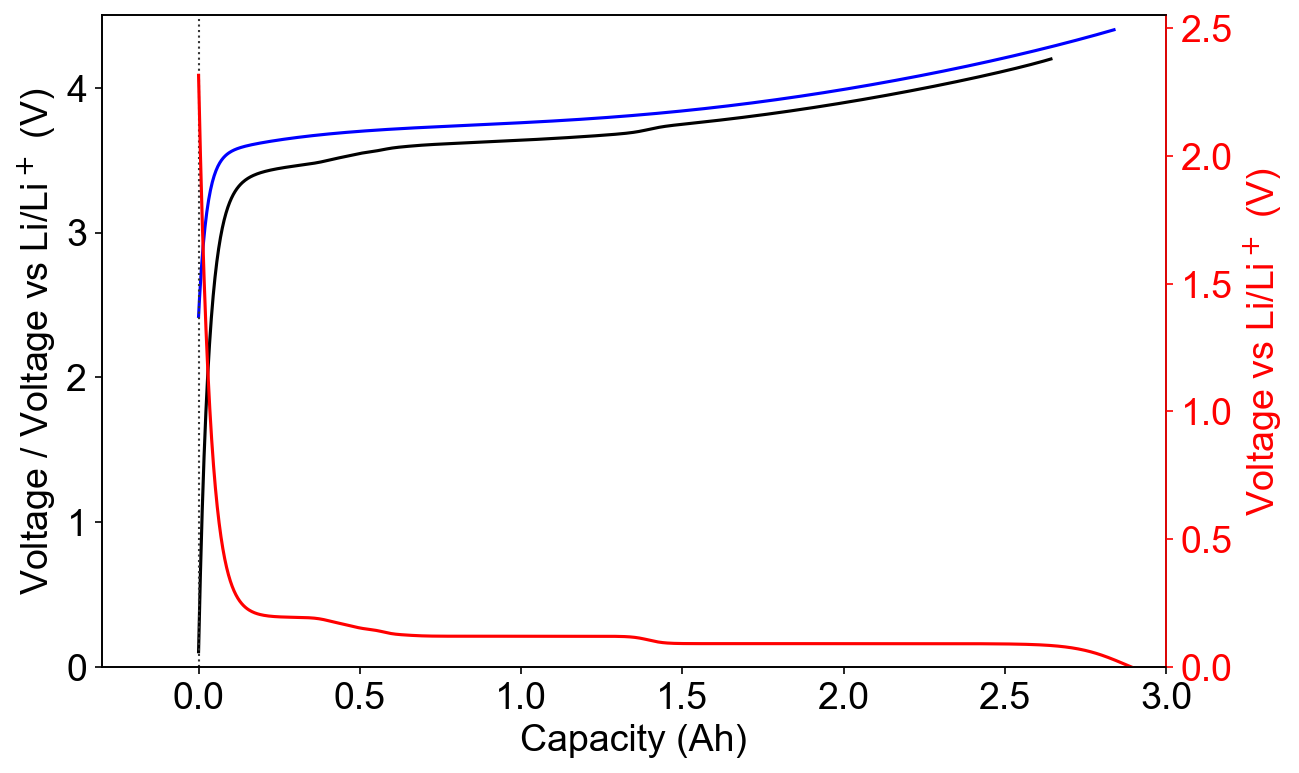

In [7]:
file_name_voltage_data_before_formation = paths['outputs'] + \
                                          'voltage_curves_before_formation.json'

with open(file_name_voltage_data_before_formation) as f:
    data = json.load(f)
    

fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()

ax.plot(data['q_pos'], data['v_pos'], color=COLOR_POS, linestyle='-')
ax.plot(data['q_full'], data['v_full'], color=COLOR_FULL, linestyle='-')
ax2.plot(data['q_neg'], data['v_neg'], color=COLOR_NEG, linestyle='-')

ax.plot([0, 0], [0, 4.5], color=COLOR_BG, linestyle=':', linewidth=1)

ax.set_xlabel('Capacity (Ah)')
ax2.yaxis.label.set_color(COLOR_NEG)
ax2.spines["right"].set_edgecolor(COLOR_NEG)
ax2.tick_params(axis='y', colors=COLOR_NEG)

ax.set_ylabel('Voltage / Voltage vs Li/Li$^+$ (V)')
ax2.set_ylabel('Voltage vs Li/Li$^+$ (V)')
ax.set_xlim((-0.3, 3))
ax2.set_ylim((0, 2.55))
ax.set_ylim((0, 4.5))

## Sample real data to construct the equilibrium curve model

We'll borrow data from the fast formation dataset to construct the equilibrium model.

In [8]:
# Initialize a container for formation cell data
cell_dict = dict()
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    cell_dict[cellid] = FormationCell(cellid)

In [9]:
# Data from cells

# Data from HPPC pulses (pre-aggregated)
df_hppc_1 = cell_dict[CELL_FAST].process_diagnostic_hppc_discharge_data()[0]['data']
df_hppc_3 = cell_dict[CELL_BASE].process_diagnostic_hppc_discharge_data()[0]['data']

# Data from the eSOH algorithm results (pre-aggregated)
df_esoh_1 = cell_dict[CELL_FAST].get_esoh_fitting_data()[0] # a fresh dataset
df_esoh_2 = cell_dict[CELL_FAST].get_esoh_fitting_data()[2] # an aged dataset
df_esoh_3 = cell_dict[CELL_BASE].get_esoh_fitting_data()[0] # a fresh dataset
df_esoh_4 = cell_dict[CELL_BASE].get_esoh_fitting_data()[3] # an aged dataset

# Summary statistics
summary_stats = cell_dict[CELL_FAST].get_formation_test_summary_statistics()
q_lli_ah_ref = summary_stats['form_first_charge_capacity_ah'] - summary_stats['form_final_discharge_capacity_ah']

In [10]:
INTERP_KIND = 'cubic' # try 'linear', 'cubic', 'quadratic'

# Unpack the data
capacity = df_hppc_1['capacity']
soc = capacity / np.max(capacity) * 100

# Build a higher fidelity, smooth signal for the equilibrium model
num_points_hifi = 300
resistance = df_hppc_1['resistance_10s_ohm']
capacity_hifi = np.linspace(np.min(capacity), np.max(capacity), num_points_hifi)
interp_fn = interpolate.interp1d(capacity, resistance, kind=INTERP_KIND)
resistance_hifi = interp_fn(capacity_hifi)
soc_hifi = capacity_hifi / np.max(capacity_hifi) * 100

 ## Initialize the dataset to plot

In [11]:
# Define the horizontal leftward cathode capacity shift for this toy model demonstration
capacity_shift_ah = 0.1
capacity_shift_ah = np.array(capacity_shift_ah)

capacity_at_5_soc = 0.05 * np.max(capacity_hifi)

q_pos = df_esoh_1['pos']['Q']
q_neg = df_esoh_1['neg']['Q']
v_pos = df_esoh_1['pos']['V']
v_neg = df_esoh_1['neg']['V']
q_full = df_esoh_1['orig']['Q']
v_full = df_esoh_1['orig']['V']

# Percentage of total cell resistance attributed to the cathode charge transfer resistance
frac_cathode_rct = 0.7

# Fast formation
fast = stoicmodel.compute_resistance_curves(capacity_hifi, resistance_hifi, 
                                   frac_cathode_rct, capacity_shift_ah, 0, False)

# Baseline formation
base = stoicmodel.compute_resistance_curves(capacity_hifi, resistance_hifi, 
                                     frac_cathode_rct, 0, 0, False)


## Compare fast formation and baseline formation voltage and resistance curve alignments

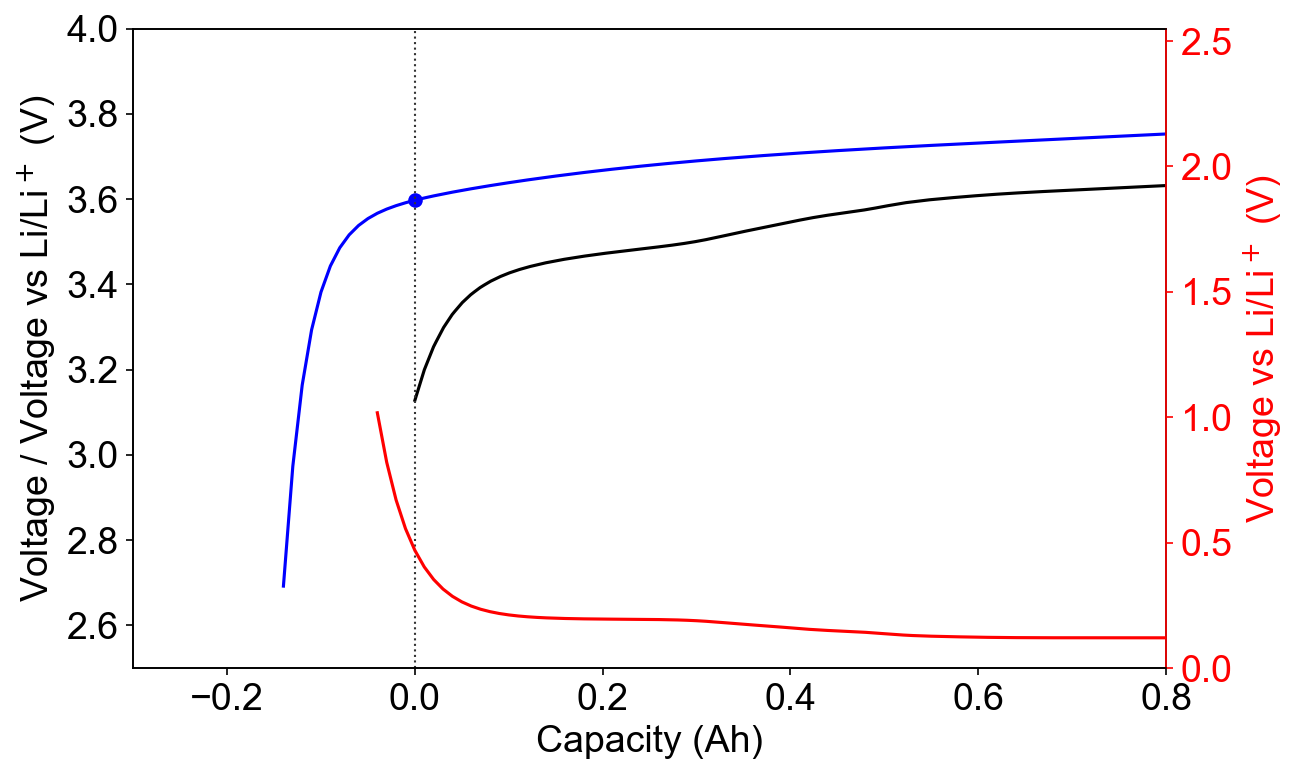

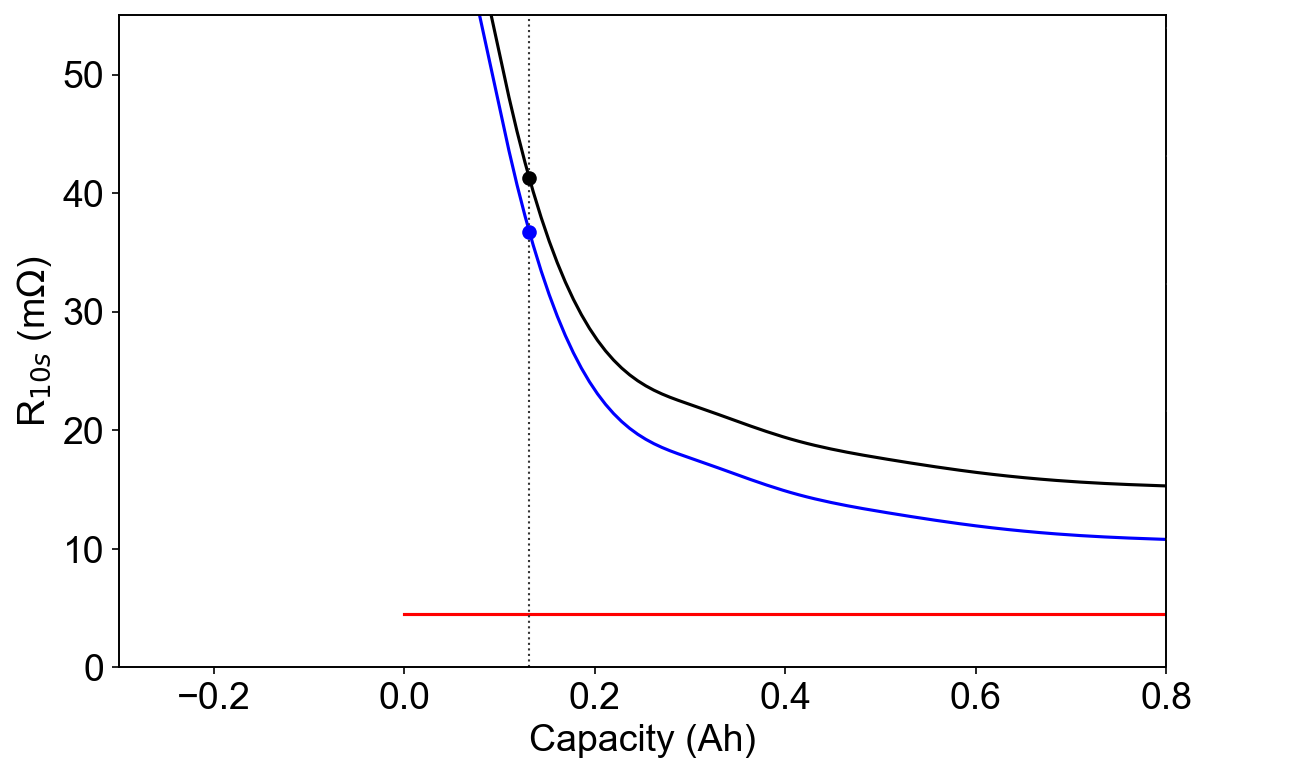

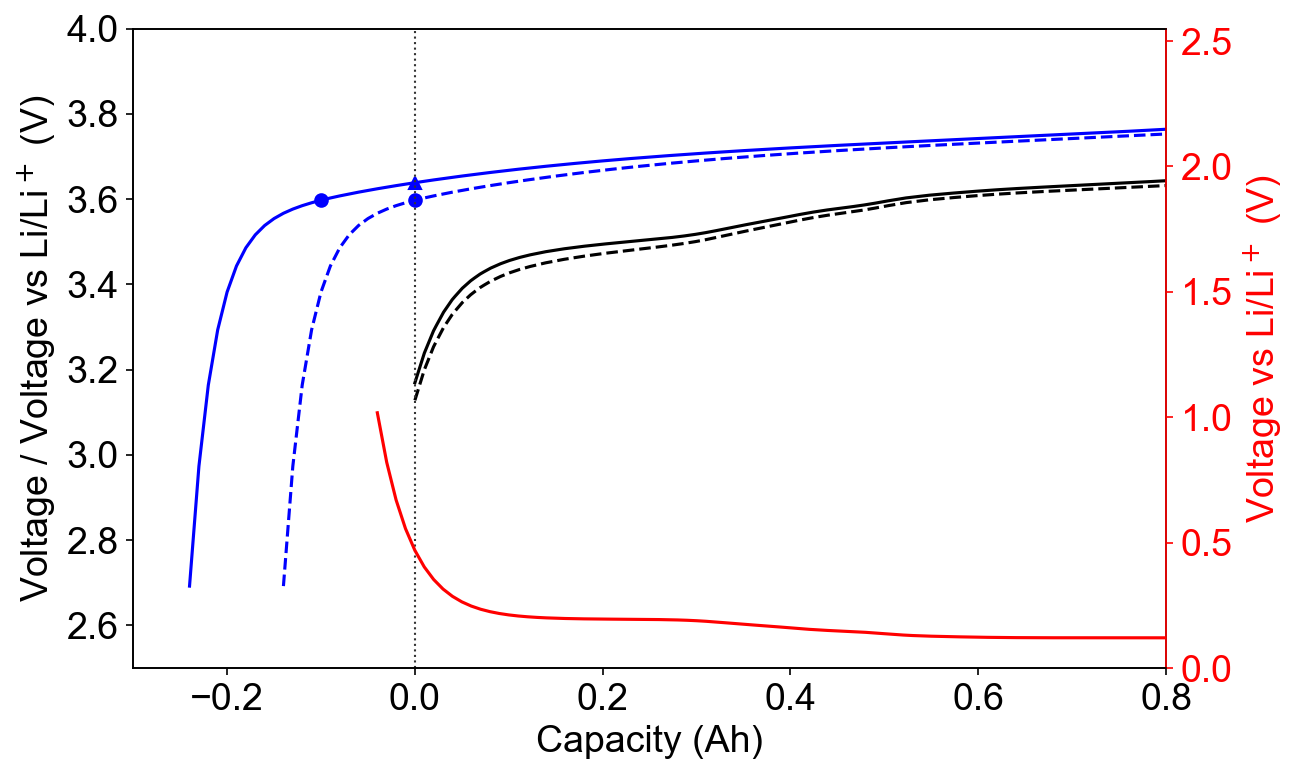

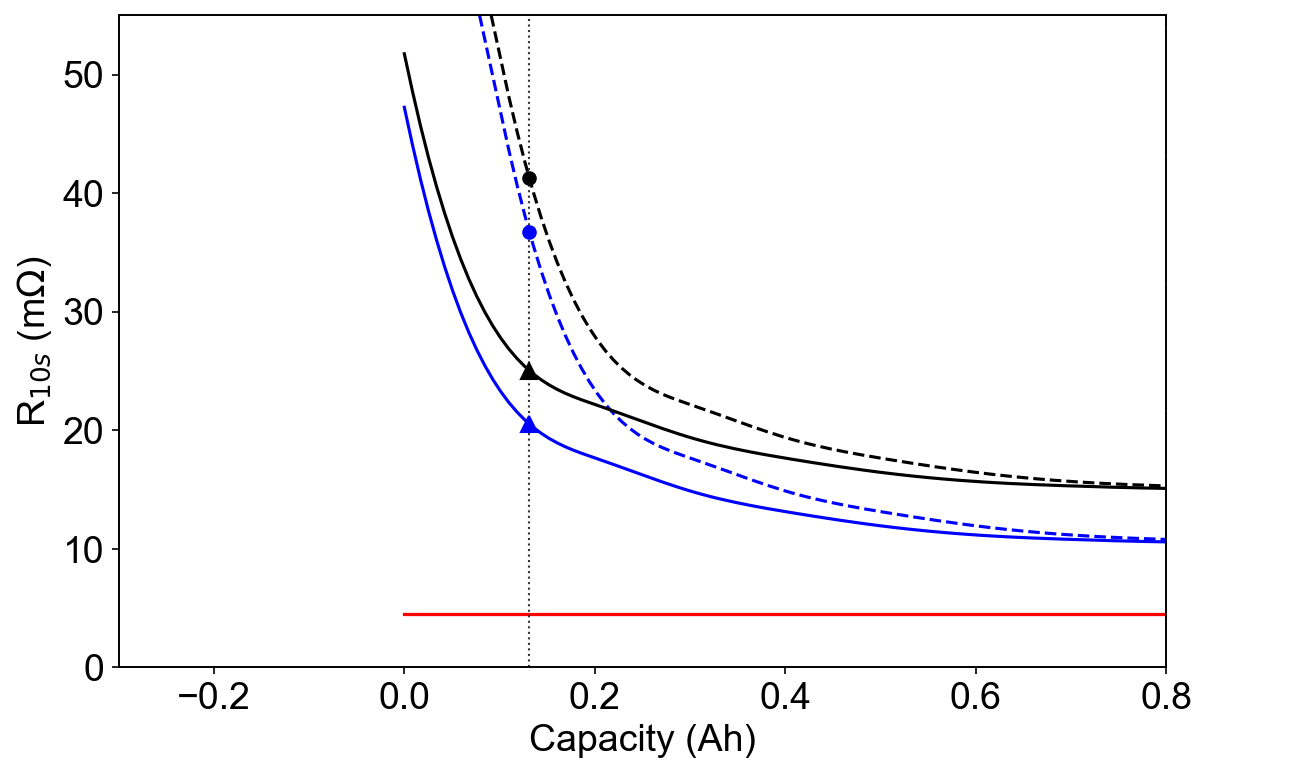

In [12]:
for include_fast in [False, True]:
    
    ls_base = '--' if include_fast else '-'
    
    fig_arr, ax_arr, ax2_arr = [], [], []

    ## First plot

    fig, ax = plt.subplots(figsize=figsize)
    ax2 = ax.twinx()

    fig_arr.append(fig)

    ax.plot(q_pos, v_pos, color=COLOR_POS, linestyle=ls_base)
    ax2.plot(q_neg, v_neg, color=COLOR_NEG)

#     ax.plot(q_full, v_full, color=COLOR_FULL, linestyle=ls_base)

    # Re-construct the full cell curve from the pos and neg electrodes
    q_shared = q_full
    fn_interp = interpolate.interp1d(q_pos, v_pos)
    v_pos_shared = fn_interp(q_shared)
    fn_interp = interpolate.interp1d(q_neg, v_neg)
    v_neg_shared = fn_interp(q_shared)
    v_full_reconst = v_pos_shared - v_neg_shared
    
    ax.plot(q_full, v_full_reconst, color=COLOR_FULL, linestyle=ls_base)

    if include_fast:
        # The shifted cathode curve
        ax.plot(q_pos - capacity_shift_ah, v_pos, color=COLOR_POS)
        
        # Re-construct the full cell curve from the new pos and neg electrodes
        q_shared = q_full
        fn_interp = interpolate.interp1d(q_pos - capacity_shift_ah, v_pos)
        v_pos_shared = fn_interp(q_shared)
        
        fn_interp = interpolate.interp1d(q_neg, v_neg)
        v_neg_shared = fn_interp(q_shared)
        
        v_full_reconst_shifted = v_pos_shared - v_neg_shared
        
        # Construct new full cell curve
        ax.plot(q_full, v_full_reconst_shifted, color=COLOR_FULL)

    # Put markers on the cathode curve at 0% SOC
    if include_fast:
        
        fn = interpolate.interp1d(q_pos, v_pos)
        ax.plot(0, fn(0), marker='o', markersize=6, 
                color=COLOR_POS, linestyle=ls_base)
       
        ax.plot(0 - capacity_shift_ah, fn(0), marker='o', markersize=6, 
                color=COLOR_POS, linestyle=ls_base)
        
        fn = interpolate.interp1d(q_pos - capacity_shift_ah, v_pos)

        ax.plot(0, fn(0), marker='^', markersize=6, 
                color=COLOR_POS, linestyle=ls_base)
        
    else:
        
        fn = interpolate.interp1d(q_pos, v_pos)
        v_pos_at_0_soc = fn(0)
        ax.plot(0, v_pos_at_0_soc, 
                marker='o', color=COLOR_POS, markersize=6)

        

    # Vertical line at 5% SOC
    ax.plot([0] * 2, [2.5, 4.5], color=COLOR_BG, linestyle=':', linewidth=1)

    ax.set_xlabel('Capacity (Ah)')
    ax.set_ylabel('Voltage / Voltage vs Li/Li$^+$ (V)')
    ax.set_xlim((-0.3, 0.8))
    ax.set_ylim((2.5, 4.0))

    ax2.tick_params(axis='y', colors=COLOR_NEG)
    ax2.yaxis.label.set_color(COLOR_NEG)
    ax2.spines["right"].set_edgecolor(COLOR_NEG)
    ax2.set_ylabel('Voltage vs Li/Li$^+$ (V)')
    ax2.set_ylim((0, 2.55))

    
    
    ## Second plot   
    fig, ax = plt.subplots(figsize=figsize)
    fig_arr.append(fig)

    ax.plot(base['capacity_expanded'], base['resistance_full_modeled'] * 1000,
            color=COLOR_FULL, linestyle=ls_base)

    ax.plot(base['capacity_expanded'], base['resistance_other'] * 1000,
             color=COLOR_NEG)

    ax.plot(base['capacity_expanded'], base['resistance_cathode'] * 1000,
            color=COLOR_POS, linestyle=ls_base)
    
    if include_fast:

        ax.plot(fast['capacity_expanded'], fast['resistance_other'] * 1000,
                 color=COLOR_NEG)

        ax.plot(fast['capacity_expanded'], fast['resistance_full_modeled'] * 1000, 
                color=COLOR_FULL)

        ax.plot(fast['capacity_expanded'], fast['resistance_cathode'] * 1000,
                color=COLOR_POS)

    # Vertical line at 5% SOC
    ax.plot([capacity_at_5_soc] * 2, [0, 55], color=COLOR_BG, linestyle=':', linewidth=1)

    # Put markers on the cathode and full cell resistance curves at 5% SOC
    fn = interpolate.interp1d(base['capacity_expanded'], base['resistance_full_modeled'])
    r_pos_at_5_soc = fn(capacity_at_5_soc)
    ax.plot(capacity_at_5_soc, r_pos_at_5_soc * 1000, marker='o', color=COLOR_FULL, markersize=6)

    fn = interpolate.interp1d(base['capacity_expanded'], base['resistance_cathode'])
    r_pos_at_5_soc = fn(capacity_at_5_soc)
    ax.plot(capacity_at_5_soc, r_pos_at_5_soc * 1000, marker='o', color=COLOR_POS, markersize=6)

    if include_fast: 

        fn = interpolate.interp1d(fast['capacity_expanded'], fast['resistance_full_modeled'])
        r_pos_at_5_soc = fn(capacity_at_5_soc)
        ax.plot(capacity_at_5_soc, r_pos_at_5_soc * 1000, marker='^', color=COLOR_FULL, markersize=8)

        fn = interpolate.interp1d(fast['capacity_expanded'], fast['resistance_cathode'])
        r_pos_at_5_soc = fn(capacity_at_5_soc)
        ax.plot(capacity_at_5_soc, r_pos_at_5_soc * 1000, marker='^', color=COLOR_POS, markersize=8)

    ax.set_xlabel('Capacity (Ah)')
    ax.set_ylabel('R$_{10s}$ (m$\Omega$)')
    ax.set_xlim((-0.3, 0.8))
    ax.set_ylim(bottom=0, top=55)
    

    # Dummy secondary y-axis to get figsize to line up
    ax2 = ax.twinx()
    ax2.plot([], [], color='w')
    ax2.tick_params(axis='y', colors='w')
    ax2.yaxis.label.set_color('w')
    ax2.spines["right"].set_edgecolor('w')
    ax2.set_ylabel('Voltage vs Li/Li$^+$ (V)')
    ax2.set_ylim((0, 2.55))
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')


## Interactive Plot 1: Zoom into low SOC Region

In [13]:
target_soc = 0.05

res_orig = stoicmodel.fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3, 
                                            frac_cathode_resistance=0.70,
                                            resistance_curves_type='default',  # default, split, swapped
                                            resistance_interp_kind='cubic')    # linear, cubic

metrics_orig = stoicmodel.compute_useful_metrics(res_orig, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)   
    
interact(stoicmodel.plot_shift, 
                     shift_mah=widgets.FloatSlider(min=-200, max=100, step=1.0),
                     pos_shrink=widgets.FloatSlider(min=0, max=0.2, step=0.005),
                     neg_shrink=widgets.FloatSlider(min=0, max=0.2, step=0.005),
                     res_orig=fixed(res_orig),
                     metrics_orig=fixed(metrics_orig),
                     target_soc=fixed(target_soc),
                     min_voltage=fixed(MIN_VOLTAGE),
                     max_voltage=fixed(MAX_VOLTAGE),
                     xlims=fixed((-0.3, 1)))

interactive(children=(FloatSlider(value=0.0, description='shift_mah', min=-200.0, step=1.0), FloatSlider(value…

<function src.stoicmodel.plot_shift(shift_mah, pos_shrink, neg_shrink, res_orig, metrics_orig, target_soc, min_voltage, max_voltage, xlims)>

## Interactive Plot 2: Full Capacity Window

In [14]:
target_soc = 0.05

res_orig = stoicmodel.fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3, 
                                            frac_cathode_resistance=0.70,
                                            resistance_curves_type='default',  # default, split, swapped
                                            resistance_interp_kind='cubic')    # linear, cubic

metrics_orig = stoicmodel.compute_useful_metrics(res_orig, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)   

interact(stoicmodel.plot_shift, 
                     shift_mah=widgets.FloatSlider(min=-200, max=100, step=10),
                     pos_shrink=widgets.FloatSlider(min=0, max=0.2, step=0.005),
                     neg_shrink=widgets.FloatSlider(min=0, max=0.2, step=0.005),
                     res_orig=fixed(res_orig),
                     metrics_orig=fixed(metrics_orig),
                     target_soc=fixed(target_soc),
                     min_voltage=fixed(MIN_VOLTAGE),
                     max_voltage=fixed(MAX_VOLTAGE),
                     xlims=fixed((-0.3, 3)))

interactive(children=(FloatSlider(value=0.0, description='shift_mah', min=-200.0, step=10.0), FloatSlider(valu…

<function src.stoicmodel.plot_shift(shift_mah, pos_shrink, neg_shrink, res_orig, metrics_orig, target_soc, min_voltage, max_voltage, xlims)>

# Visualize sensitivities

In [15]:
# Configure globals

res_orig = stoicmodel.fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3,
                                           resistance_curves_type='default',
                                           resistance_interp_kind='cubic')
target_soc_vec = [0.02, 0.05, 0.07, 0.1]
colors = plt.cm.winter(np.linspace(0, 1, len(target_soc_vec)))
top_or_bottom_vec = ['top', 'bottom']

# Define noise constants (see 'signal_to_noise_analysis.ipynb')
#
# SOC = 2% : 2.615 mAh
# SOC = 5% : 4.067 mAh
# SOC = 7% : 7.321 mAh
# SOC = 10% : 36.604 mAh

# Error in Q_LLI estimation based on Qd
q_error_mah = 22.22

# Error in Q_LLI estimation based on RLS
# (depends on slopes)
# 2, 5, 7, 10%
rls_error_mah = [2.615, 4.067, 7.321, 36.604] 

## Comparison of RLS and Qd as measures of lithium consumption

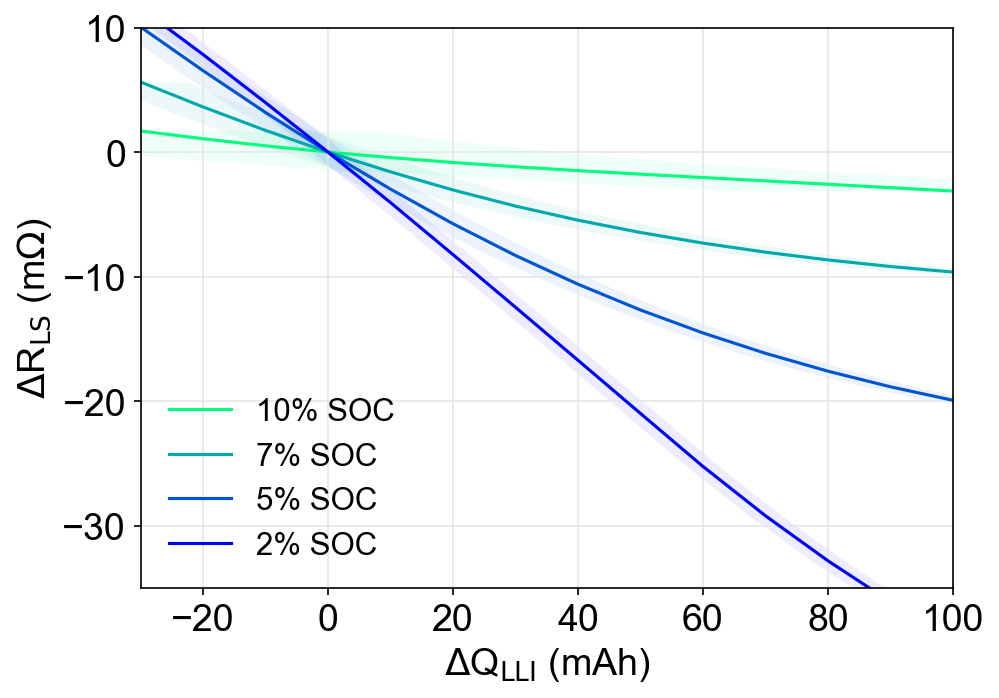

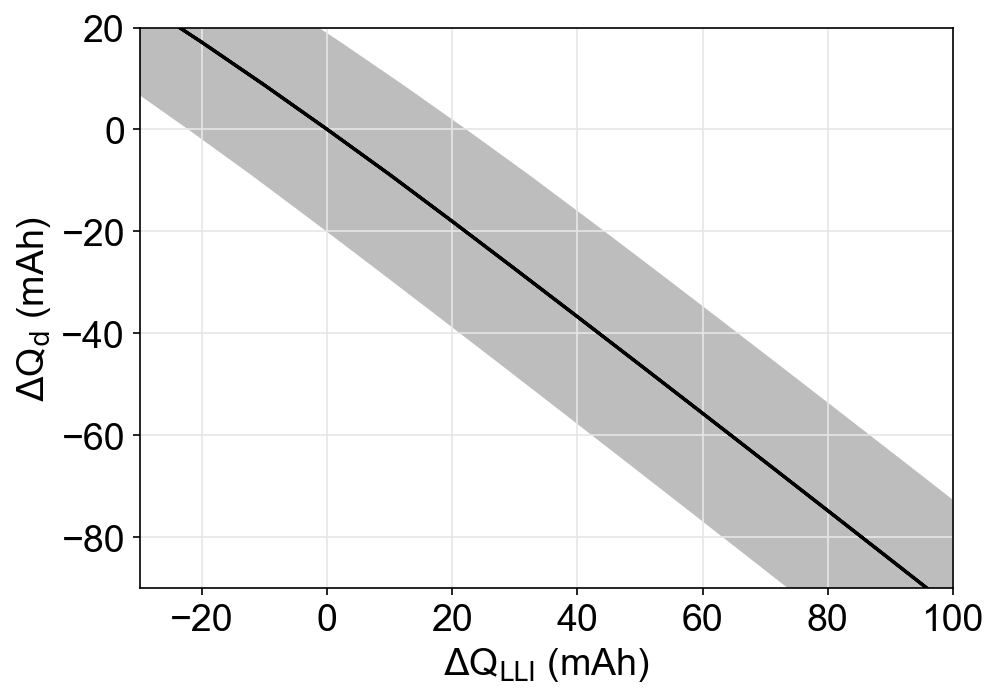

In [16]:
shift_ah_vec = np.arange(-0.1, 0.031, 0.01)

plt.figure()
ax1 = plt.gca()

plt.figure()
ax2 = plt.gca()

for i, target_soc in reversed(list(enumerate(target_soc_vec))):
    
    metrics_orig = stoicmodel.compute_useful_metrics(res_orig, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

    res_target_soc_vec = []
    cell_cap_vec = []

    for shift_ah in shift_ah_vec:
    
        res = stoicmodel.voltage_resistance_transform(res_orig, shift_ah)

        metrics = stoicmodel.compute_useful_metrics(res, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

        res_target_soc_vec.append(metrics['resistance_at_target_soc'])
        cell_cap_vec.append(metrics['cell_cap'])

    res_target_soc_vec = np.array(res_target_soc_vec)
    cell_cap_vec = np.array(cell_cap_vec)

    delta_qlli = -shift_ah_vec
    
    x = delta_qlli * 1000
    y = (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000
    
    ax1.plot(x, y,
             label=f'{target_soc * 100 :.0f}% SOC ',
             color=colors[i])
    
    # Plot noise in the RLS measuremet converted to QLLI estimation inaccuracy
    ax1.fill_betweenx(y, x - rls_error_mah[i], x + rls_error_mah[i], color=colors[i], alpha=0.07, linewidth=0.0)
    ax1.set_xlabel('$\Delta$Q$_{\mathrm{LLI}}$ (mAh)')
    ax1.set_ylabel('$\Delta$R$_\mathrm{LS}$ (m$\Omega$)')
    ax1.set_xlim(np.min(delta_qlli) * 1000, np.max(delta_qlli) * 1000)
    ax1.set_ylim((-35, 10))
    ax1.grid(True, color=(0.9, 0.9, 0.9))

    
    # The capacity plot
    x = delta_qlli * 1000
    y = (cell_cap_vec - metrics_orig['cell_cap']) * 1000
    
    ax2.plot(x, y, color='k')
    
    # Plot noise in the Qd measurement converted into QLLI estimation inaccuracy
    ax2.fill_betweenx(y, x - q_error_mah, x + q_error_mah, 
                     color='k', alpha=0.07, linewidth=0.0)
    
    ax2.set_xlabel('$\Delta$Q$_{\mathrm{LLI}}$ (mAh)')
    ax2.set_ylabel('$\Delta$Q$_\mathrm{d}$ (mAh)')
    
    ax2.set_xlim(np.min(delta_qlli) * 1000, np.max(delta_qlli) * 1000)
    ax2.set_ylim((-90, 20))
    ax2.grid(True, color=(0.9, 0.9, 0.9))
    
ax1.legend(prop={'size': 15}, frameon=False)

# Impact of positive electrode active material losses

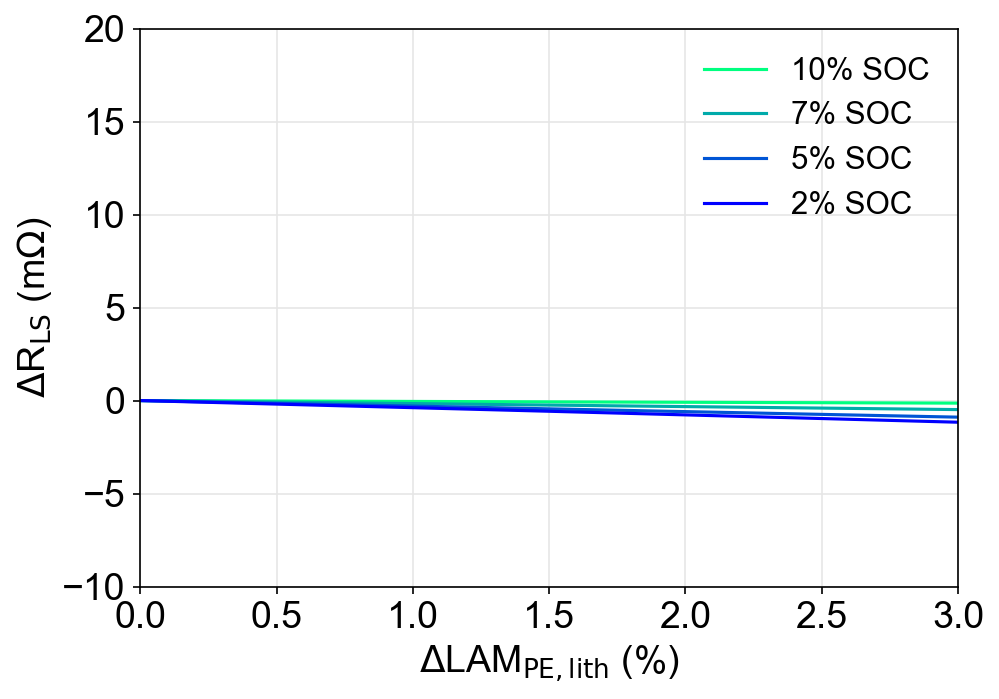

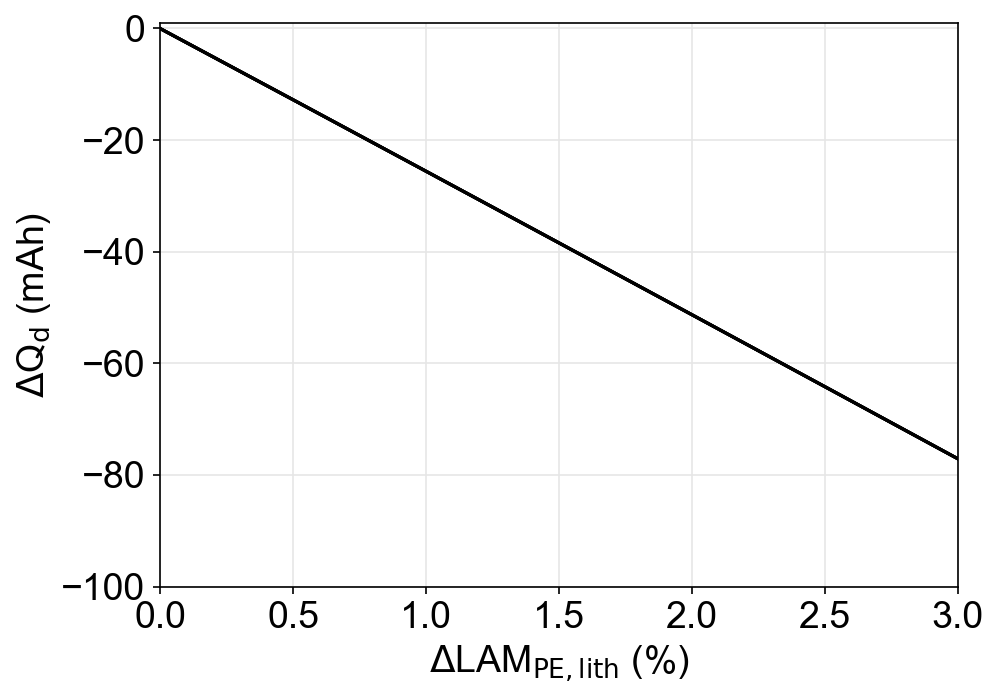

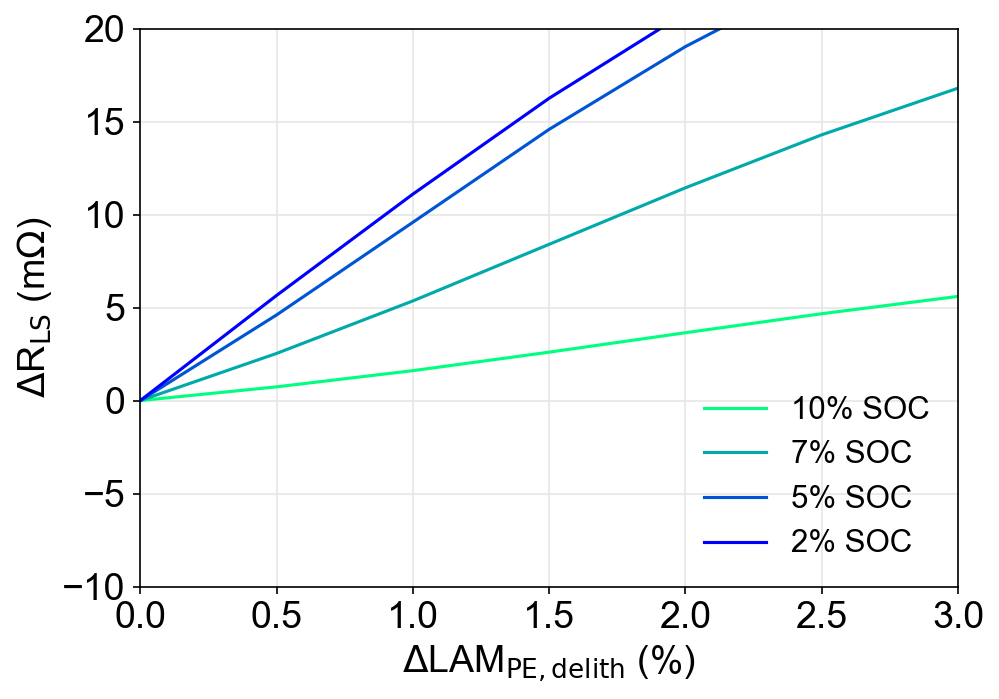

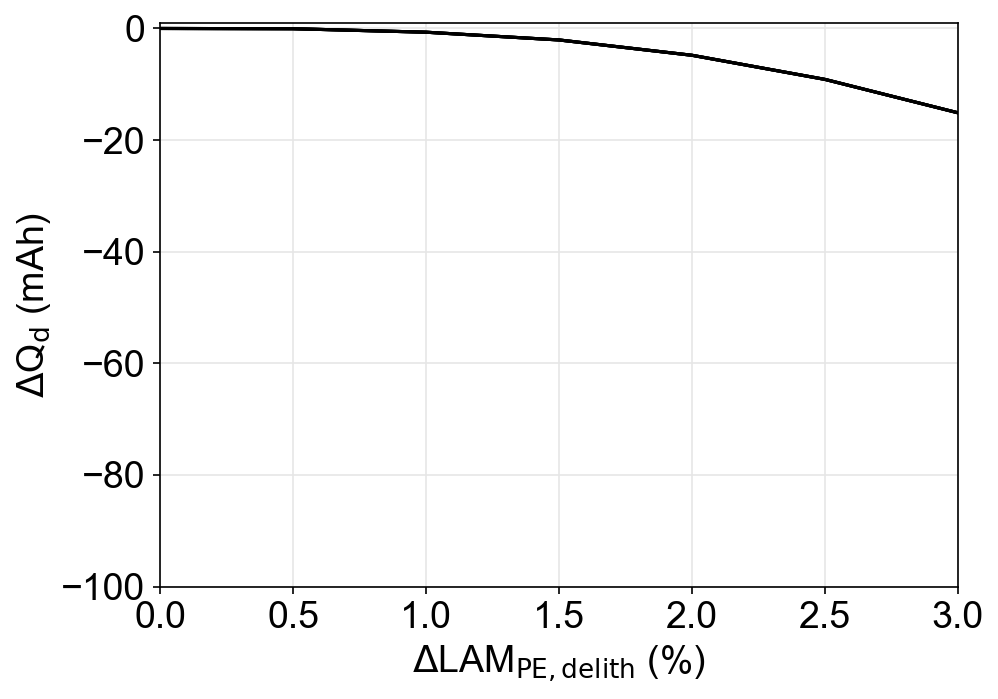

In [17]:
shift_ah = 0

pos_shrink_frac_vec = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030])

top_or_bottom_vec = ['top', 'bottom']

for top_or_bottom in top_or_bottom_vec:
    
    top_bottom_str = 'delith' if top_or_bottom == 'bottom' else 'lith'

    plt.figure()
    ax1 = plt.gca()

    plt.figure()
    ax2 = plt.gca()

    for i, target_soc in reversed(list(enumerate(target_soc_vec))):

        metrics_orig = stoicmodel.compute_useful_metrics(res_orig, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

        res_target_soc_vec = []
        cell_cap_vec = []

        for pos_shrink_frac in pos_shrink_frac_vec:

            res = stoicmodel.voltage_resistance_transform(res_orig, shift_ah,
                                              pos_shrink_loc=top_or_bottom,
                                              pos_shrink_frac=pos_shrink_frac)

            metrics = stoicmodel.compute_useful_metrics(res, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

            res_target_soc_vec.append(metrics['resistance_at_target_soc'])
            cell_cap_vec.append(metrics['cell_cap'])

        res_target_soc_vec = np.array(res_target_soc_vec)
        cell_cap_vec = np.array(cell_cap_vec)

        ax1.plot(pos_shrink_frac_vec * 100, (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000,
                label=f'{target_soc * 100 :.0f}% SOC',
                 color=colors[i])

        ax1.set_xlabel(f'$\Delta$LAM$_{{\mathrm{{PE, {top_bottom_str}}}}}$ (%)')
        ax1.set_ylabel('$\Delta$R$_\mathrm{LS}$ (m$\Omega$)')
        ax1.set_xlim(np.min(pos_shrink_frac_vec) * 100, np.max(pos_shrink_frac_vec) * 100)
        ax1.set_ylim((-10, 20))
        ax1.grid(True, color=(0.9, 0.9, 0.9))


        x = pos_shrink_frac_vec * 100
        y = (cell_cap_vec - metrics_orig['cell_cap']) * 1000
        
        ax2.plot(x, y, color='k')
        ax2.set_xlabel(f'$\Delta$LAM$_{{\mathrm{{PE, {top_bottom_str}}}}}$ (%)')
        ax2.set_ylabel('$\Delta$Q$_\mathrm{d}$ (mAh)')
        ax2.set_xlim(np.min(pos_shrink_frac_vec) * 100, np.max(pos_shrink_frac_vec) * 100)
        ax2.set_ylim((-100, 1))
        ax2.grid(True, color=(0.9, 0.9, 0.9))


    ax1.legend(prop={'size': 15}, frameon=False)

# Impact of negative electrode active material losses

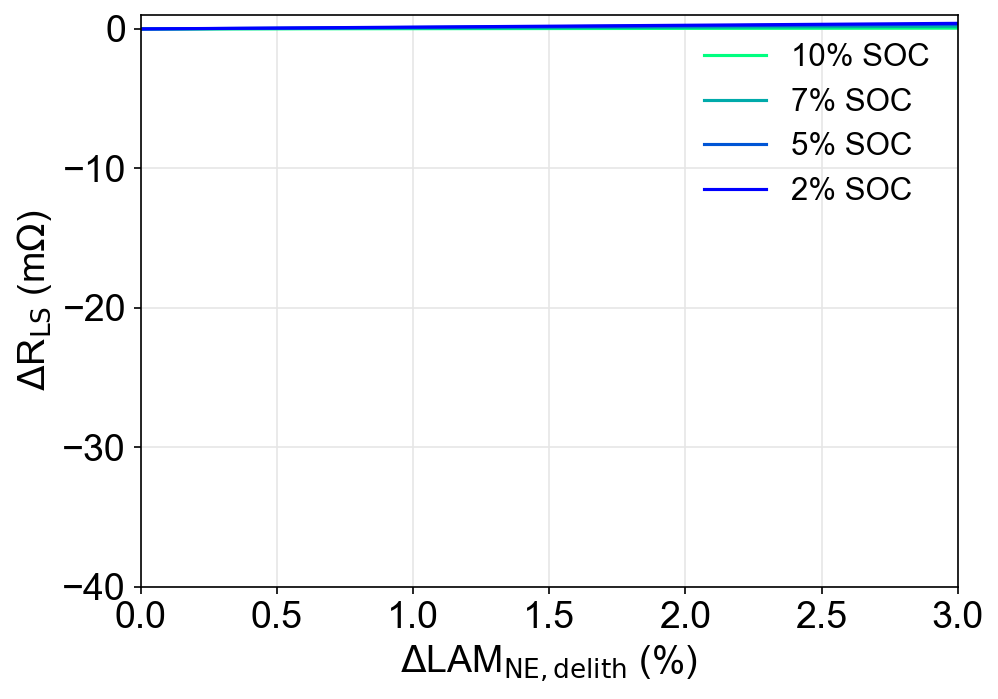

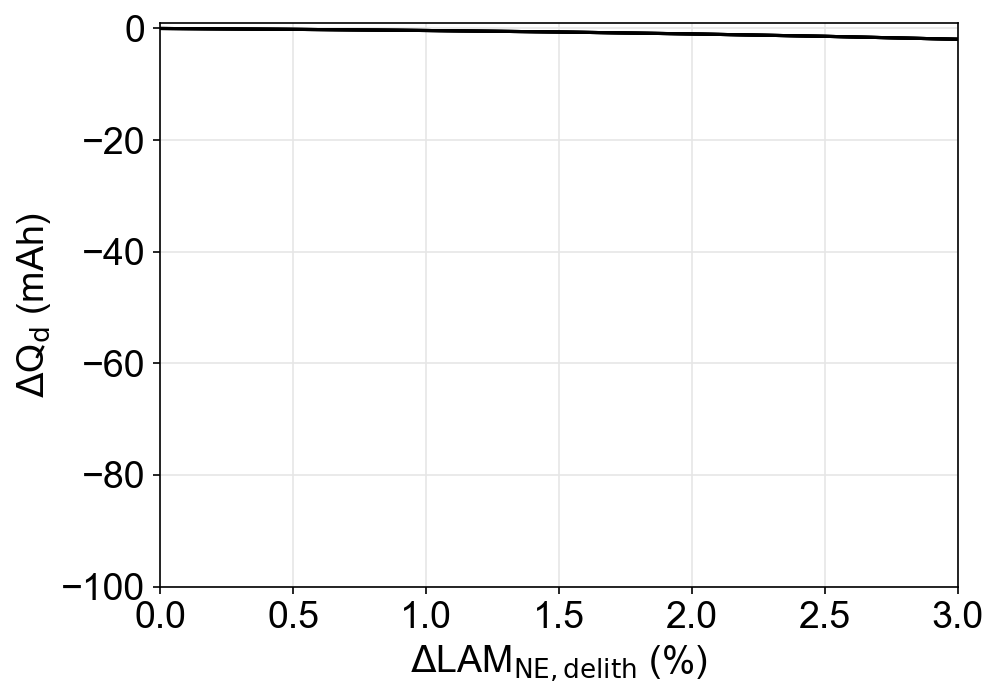

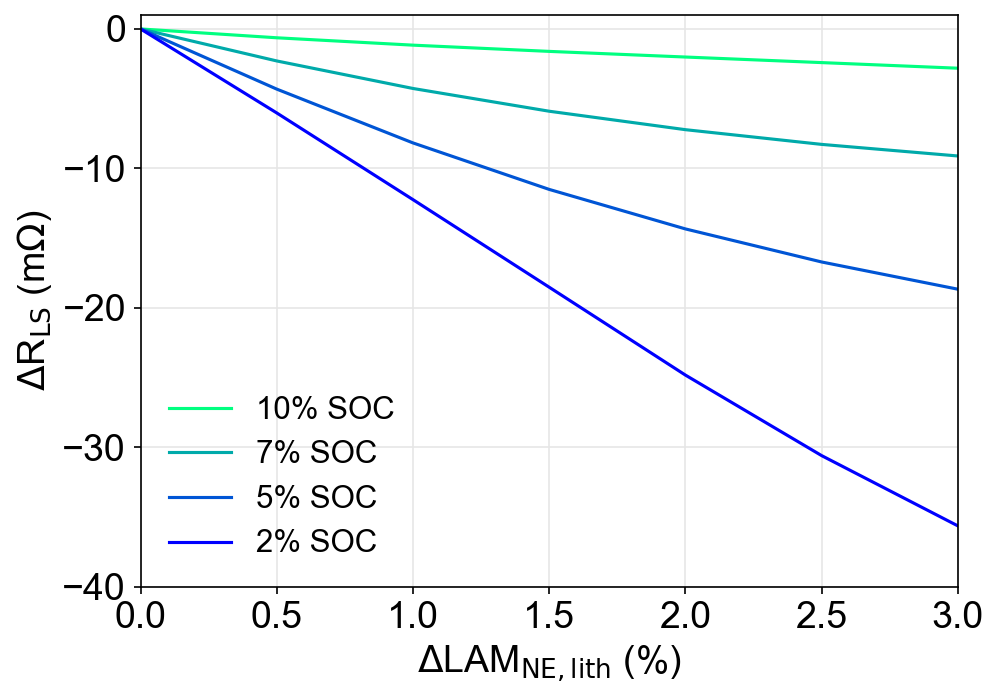

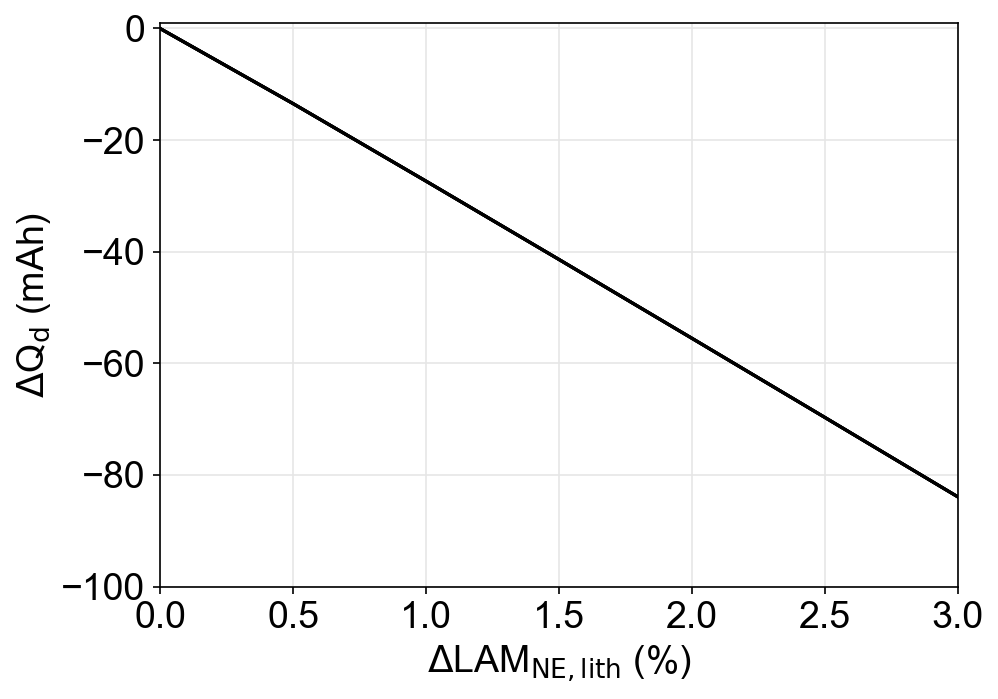

In [18]:
shift_ah = 0

neg_shrink_frac_vec = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030])

top_or_bottom_vec = ['top', 'bottom']

for top_or_bottom in top_or_bottom_vec:
    
    top_bottom_str = 'lith' if top_or_bottom == 'bottom' else 'delith'

    plt.figure()
    ax1 = plt.gca()

    plt.figure()
    ax2 = plt.gca()

    for i, target_soc in reversed(list(enumerate(target_soc_vec))):

        metrics_orig = stoicmodel.compute_useful_metrics(res_orig, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

        res_target_soc_vec = []
        cell_cap_vec = []

        for neg_shrink_frac in neg_shrink_frac_vec:

            res = stoicmodel.voltage_resistance_transform(res_orig, shift_ah,
                                              neg_shrink_loc=top_or_bottom,
                                              neg_shrink_frac=neg_shrink_frac)

            metrics = stoicmodel.compute_useful_metrics(res, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

            res_target_soc_vec.append(metrics['resistance_at_target_soc'])
            cell_cap_vec.append(metrics['cell_cap'])

        res_target_soc_vec = np.array(res_target_soc_vec)
        cell_cap_vec = np.array(cell_cap_vec)

        ax1.plot(neg_shrink_frac_vec * 100, (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000,
                label=f'{target_soc * 100 :.0f}% SOC',
                 color=colors[i])

        ax1.set_xlabel(f'$\Delta$LAM$_{{\mathrm{{NE, {top_bottom_str}}}}}$ (%)')
        ax1.set_ylabel('$\Delta$R$_\mathrm{LS}$ (m$\Omega$)')
        ax1.set_xlim(np.min(neg_shrink_frac_vec) * 100, np.max(neg_shrink_frac_vec) * 100)
        ax1.set_ylim((-40, 1))
        ax1.grid(True, color=(0.9, 0.9, 0.9))


        x = neg_shrink_frac_vec * 100
        y = (cell_cap_vec - metrics_orig['cell_cap']) * 1000
        
        ax2.plot(x, y, color='k')
        ax2.set_xlabel(f'$\Delta$LAM$_{{\mathrm{{NE, {top_bottom_str}}}}}$ (%)')
        ax2.set_ylabel('$\Delta$Q$_\mathrm{d}$ (mAh)')
        ax2.set_xlim(np.min(neg_shrink_frac_vec) * 100, np.max(neg_shrink_frac_vec) * 100)
        ax2.set_ylim((-100, 1))
        ax2.grid(True, color=(0.9, 0.9, 0.9))


    ax1.legend(prop={'size': 15}, frameon=False)

# Compare the different LAM sensitivities altogether

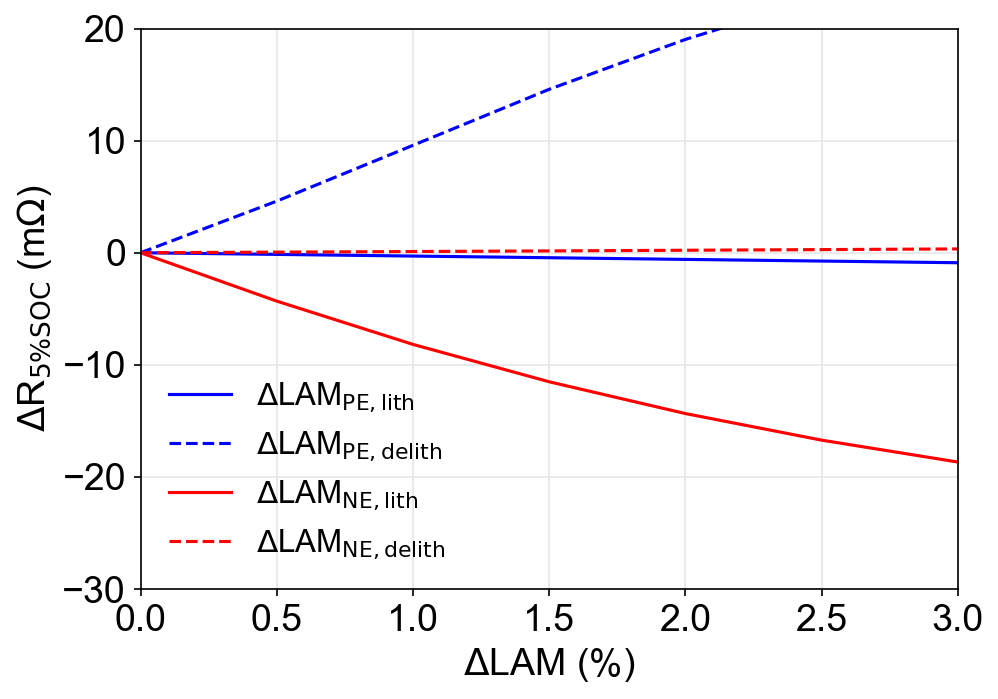

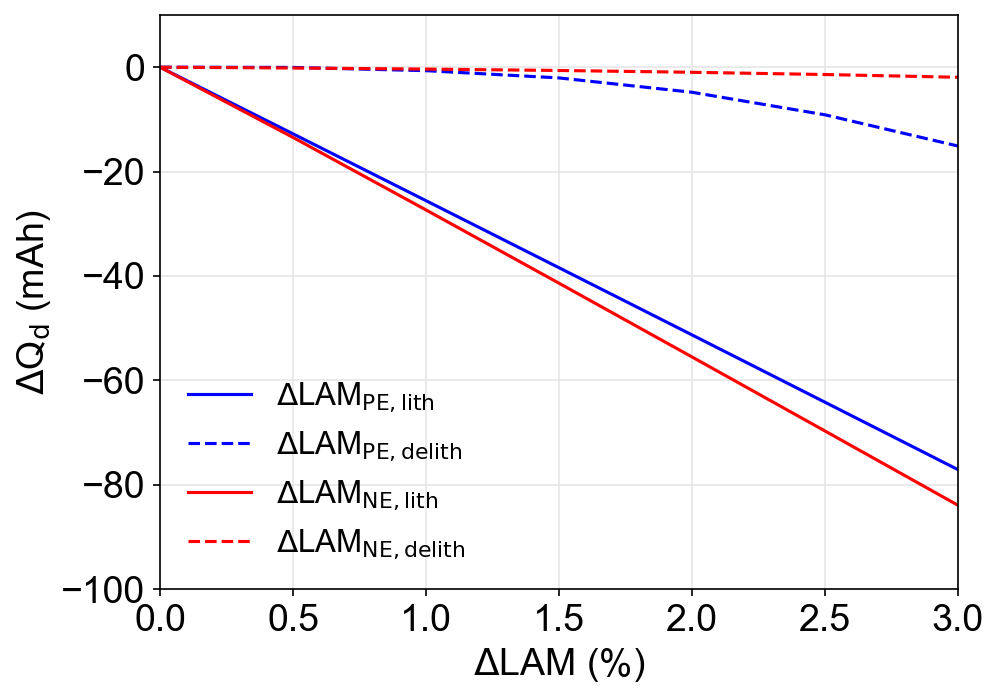

In [19]:
shift_ah = 0
target_soc = 0.05

shrink_frac_vec = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030])

lam_type_vec = ['lampe', 'lampe', 'lamne', 'lamne']
top_or_bottom_vec = ['top', 'bottom', 'bottom', 'top']
label_vec = ['$\Delta$LAM$_{{\mathrm{{PE,lith}}}}$', 
             '$\Delta$LAM$_{{\mathrm{{PE,delith}}}}$',
             '$\Delta$LAM$_{{\mathrm{{NE,lith}}}}$',
             '$\Delta$LAM$_{{\mathrm{{NE,delith}}}}$']
colors_vec = ['b', 'b', 'r', 'r']
linestyle_vec = ['-', '--', '-', '--']

plt.figure()
ax1 = plt.gca()

plt.figure()
ax2 = plt.gca()

for (lam_type, top_or_bottom, label, color, linestyle) in \
zip(lam_type_vec, top_or_bottom_vec, label_vec, colors_vec, linestyle_vec):

    metrics_orig = stoicmodel.compute_useful_metrics(res_orig, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

    res_target_soc_vec = []
    cell_cap_vec = []

    for shrink_frac in shrink_frac_vec:

        if lam_type == 'lampe':
            
            res = stoicmodel.voltage_resistance_transform(res_orig, shift_ah,
                                              pos_shrink_loc=top_or_bottom,
                                              pos_shrink_frac=shrink_frac)

        elif lam_type == 'lamne':
            
            res = stoicmodel.voltage_resistance_transform(res_orig, shift_ah,
                                              neg_shrink_loc=top_or_bottom,
                                              neg_shrink_frac=shrink_frac)
            
        metrics = stoicmodel.compute_useful_metrics(res, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

        res_target_soc_vec.append(metrics['resistance_at_target_soc'])
        cell_cap_vec.append(metrics['cell_cap'])

    res_target_soc_vec = np.array(res_target_soc_vec)
    cell_cap_vec = np.array(cell_cap_vec)

    ax1.plot(neg_shrink_frac_vec * 100, 
            (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000,
            label=label,
            color=color,
            linestyle=linestyle)
    
    ax2.plot(neg_shrink_frac_vec * 100, 
            (cell_cap_vec - metrics_orig['cell_cap']) * 1000,
            color=color, linestyle=linestyle,
            label=label)

ax1.set_xlabel('$\Delta$LAM (%)')
ax1.set_ylabel(f'$\Delta$R$_{{{target_soc * 100:.0f}\% \mathrm{{SOC}}}}$ (m$\Omega$)')
ax1.set_xlim(np.min(neg_shrink_frac_vec) * 100, np.max(neg_shrink_frac_vec) * 100)
ax1.set_ylim((-30, 20))
ax1.grid(True, color=(0.9, 0.9, 0.9))


ax2.set_xlabel('$\Delta$LAM (%)')
ax2.set_ylabel('$\Delta$Q$_\mathrm{d}$ (mAh)')
ax2.set_xlim(np.min(neg_shrink_frac_vec) * 100, np.max(neg_shrink_frac_vec) * 100)
ax2.set_ylim((-100, 10))
ax2.grid(True, color=(0.9, 0.9, 0.9))


ax1.legend(prop={'size': 15}, frameon=False)
ax2.legend(prop={'size': 15}, frameon=False)

# Impact of fraction of resistance from cathode (assuming proportional split)

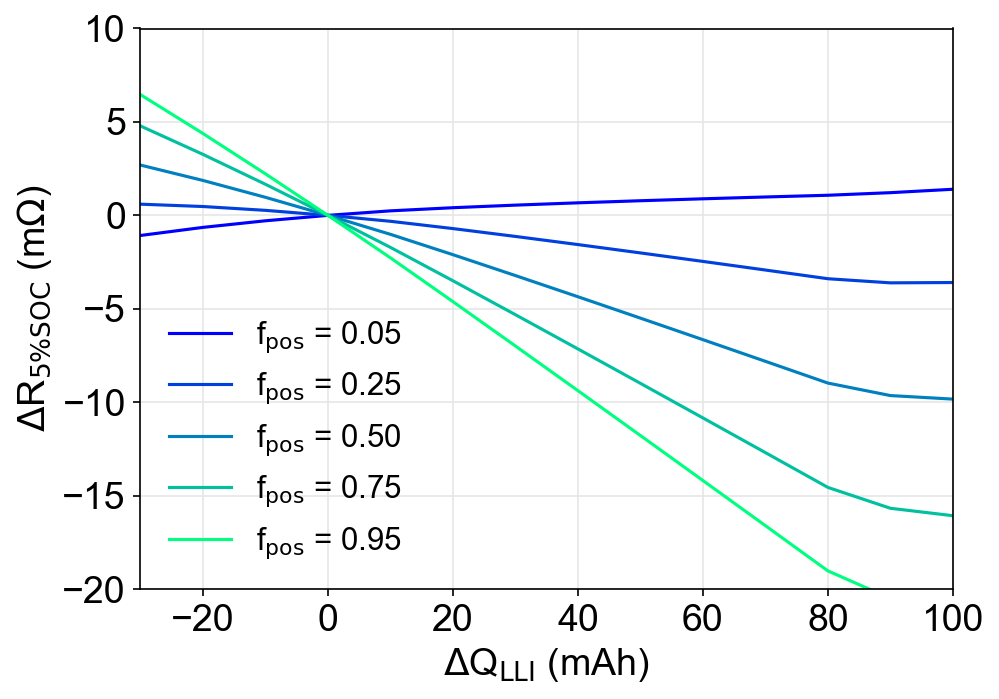

In [20]:
frac_cathode_resistance_vec = np.array([0.05, 0.25, 0.50, 0.75, 0.95])

color_vec = plt.cm.winter(np.linspace(0, 1, len(frac_cathode_resistance_vec)))

target_soc = 0.05

shift_ah_vec = np.arange(-0.1, 0.031, 0.01)

plt.figure()
ax1 = plt.gca()

for i, frac_cathode_resistance in enumerate(frac_cathode_resistance_vec):

    res_orig = stoicmodel.fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3,
                                               resistance_curves_type='split',
                                               frac_cathode_resistance=frac_cathode_resistance)

    metrics_orig = stoicmodel.compute_useful_metrics(res_orig, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)



    res_target_soc_vec = []
    cell_cap_vec = []

    for shift_ah in shift_ah_vec:

        res = stoicmodel.voltage_resistance_transform(res_orig, shift_ah)

        metrics = stoicmodel.compute_useful_metrics(res, MIN_VOLTAGE, MAX_VOLTAGE, target_soc)

        res_target_soc_vec.append(metrics['resistance_at_target_soc'])
        cell_cap_vec.append(metrics['cell_cap'])

    res_target_soc_vec = np.array(res_target_soc_vec)
    cell_cap_vec = np.array(cell_cap_vec)

    delta_qlli = -shift_ah_vec

    x = delta_qlli * 1000
    y = (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000

    ax1.plot(x, y,
             label=f'f$_\mathrm{{pos}}$ = {frac_cathode_resistance :.2f}',
             color=color_vec[i])

# Plot noise in the RLS measuremet converted to QLLI estimation inaccuracy
ax1.set_xlabel('$\Delta$Q$_{\mathrm{LLI}}$ (mAh)')
ax1.set_ylabel('$\Delta$R$_\mathrm{5\% SOC}$ (m$\Omega$)')
ax1.set_xlim(np.min(delta_qlli) * 1000, np.max(delta_qlli) * 1000)
ax1.set_ylim((-20, 10))
ax1.grid(True, color=(0.9, 0.9, 0.9))
ax1.legend(prop={'size': 15}, frameon=False)